# Experiments with p4679 and Cascadia
## Imports and set directories

In [1]:
# Imports
import sys

from utils.paths import MAIN_DIRECTORY, REL_DATA_DIR

if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import scripts.models.lstm_oneshot_multistep as lstm
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import plot_example_sample, plot_single_seg_result

# Set random seed and torch device
SEED = 42  # random seed for the dataset and model
set_seed(SEED)
device = set_torch_device()
# device = "cpu" # Manual Override

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


## Load p4679 and p4679 into dataframes

In [18]:
# Load p4679 data (average for segment 1)

exp = "cascadia"
dataset = SlowEarthquakeDataset(exp)
df_cascadia = pd.DataFrame(
    SlowEarthquakeDataset.convert_to_df(dataset, exp)["seg_avg"].rename(
        "signal"
    )
)

print("df_cascadia:")
print(df_cascadia.head())
print(df_cascadia.shape)

# Load full p4679 dataset

p4679_FILE_PATH = f"{MAIN_DIRECTORY}/{REL_DATA_DIR}/gtc_quakes_data/labquakes/Marone/p4679/p4679.txt"

df_p4679 = pd.read_csv(
    p4679_FILE_PATH,
    skiprows=2,
    usecols=["shr_stress", "time"],
    names=[
        "id",
        "lp_disp",
        "shr_stress",
        "nor_disp",
        "nor_stress",
        "time",
        "mu",
        "layer_thick",
        "ec_disp",
    ],
)

# df_p4679_300s = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 4533.28)].reset_index(drop=True)
# df_p4679 = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 5159.292)].reset_index(drop=True)

df_p4679 = df_p4679[
    (df_p4679["time"] >= 4559) & (df_p4679["time"] <= 5159)
].reset_index(drop=True)
df_p4679_300s = df_p4679[
    (df_p4679["time"] >= 4859) & (df_p4679["time"] <= 5159)
].reset_index(drop=True)

df_p4679 = df_p4679.rename(columns={"shr_stress": "signal"}).drop(
    columns=["time"]
)  # Remove 'time' column
df_p4679_300s = df_p4679_300s.rename(columns={"shr_stress": "signal"}).drop(
    columns=["time"]
)  # Remove 'time' column

print("\n----------------")
print("df_p4679:")
print(df_p4679.head())
print(df_p4679.shape)

print("\n----------------")
print("df_p4679_300s:")
print(df_p4679_300s.head())
print(df_p4679_300s.shape)

df_cascadia:
         signal
0  1.510314e+08
1  1.256806e+08
2  1.074901e+08
3  1.447256e+08
4  1.787377e+08
(3883, 1)

----------------
df_p4679:
     signal
0  4.981327
1  4.981162
2  4.981410
3  4.981305
4  4.981106
(600001, 1)

----------------
df_p4679_300s:
     signal
0  4.886188
1  4.886326
2  4.886574
3  4.886967
4  4.886685
(300001, 1)


## Pre-processing
### Smooth both dataframes and downsample p4679 so it matches p4679

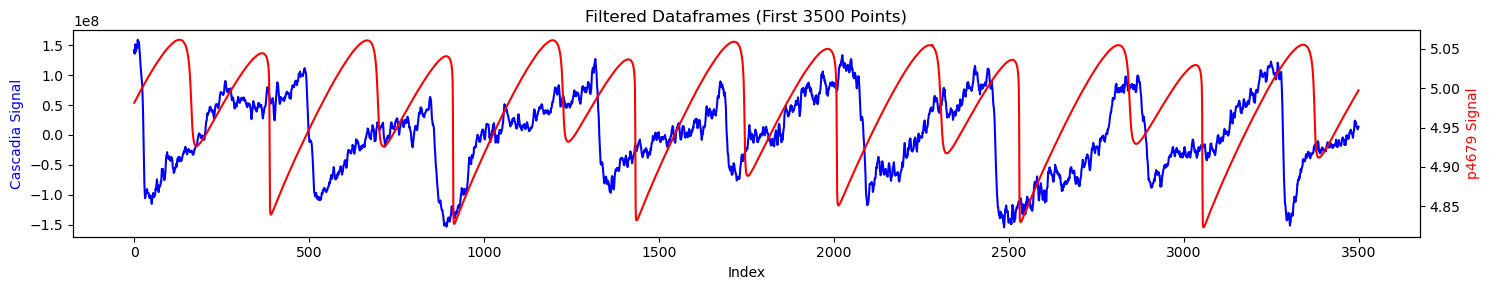

In [19]:
efficiency_factor = 1

df_cascadia_filtered = moving_average_causal_filter(
    df_cascadia, 5, 1 * efficiency_factor
)
df_p4679_filtered = moving_average_causal_filter(
    df_p4679, 13, 13 * efficiency_factor
)
df_p4679_300s_filtered = moving_average_causal_filter(
    df_p4679_300s, 13, 13 * efficiency_factor
)

fig, ax1 = plt.subplots(figsize=(15, 3))

# Plot Cascadia dataframe on the left y-axis without legend
df_cascadia_filtered[:3500].plot(
    ax=ax1, y="signal", color="blue", legend=False
)
ax1.set_xlabel("Index")
ax1.set_ylabel("Cascadia Signal", color="blue")
ax1.grid(False)

# Create a secondary y-axis for p4679 dataframe without legend
ax2 = ax1.twinx()
df_p4679_filtered[:3500].plot(ax=ax2, y="signal", color="red", legend=False)
ax2.set_ylabel("p4679 Signal", color="red")
ax2.grid(False)

plt.title("Filtered Dataframes (First 3500 Points)")
plt.tight_layout()
plt.show()

### Create Xs and ys

In [20]:
# Dataset parameters
LOOKBACK, FORECAST = int(600 / efficiency_factor), int(
    60 / efficiency_factor
)  # lookback and forecast values

# Pre-process the data into windows
X_cascadia, y_cascadia = create_dataset(
    df_cascadia_filtered, LOOKBACK, FORECAST
)
X_cascadia = X_cascadia.squeeze(-1)
y_cascadia = y_cascadia.squeeze(-1)
print(f"Cascadia X and y shapes:\t{X_cascadia.shape}\t\t{y_cascadia.shape}")

X_p4679, y_p4679 = create_dataset(df_p4679_filtered, LOOKBACK, FORECAST)
X_p4679 = X_p4679.squeeze(-1)
y_p4679 = y_p4679.squeeze(-1)
print(f"p4679 X and y shapes:\t\t{X_p4679.shape}\t{y_p4679.shape}")

X_p4679_300s, y_p4679_300s = create_dataset(
    df_p4679_300s_filtered, LOOKBACK, FORECAST
)
X_p4679_300s = X_p4679_300s.squeeze(-1)
y_p4679_300s = y_p4679_300s.squeeze(-1)
print(
    f"p4679_300s X and y shapes:\t{X_p4679_300s.shape}\t{y_p4679_300s.shape}"
)

Cascadia X and y shapes:	torch.Size([3220, 600])		torch.Size([3220, 60])
p4679 X and y shapes:		torch.Size([45494, 600])	torch.Size([45494, 60])
p4679_300s X and y shapes:	torch.Size([22417, 600])	torch.Size([22417, 60])


### Train-Val-Test Split

In [21]:
N_FORECAST_WINDOWS = int(
    20 / efficiency_factor
)  # n forecasted windows in test set
N_VALIDATION_WINDOWS = int(
    20 / efficiency_factor
)  # n forecasted windows in validation set

# Split cascadia into train-val-test sets
(
    X_train_cascadia,
    y_train_cascadia,
    X_val_cascadia,
    y_val_cascadia,
    X_test_cascadia,
    y_test_cascadia,
) = split_train_test_forecast_windows(
    X_cascadia, y_cascadia, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print("Cascadia dataset statistics:")
print(
    f"Training data shapes:\t\t{X_train_cascadia.shape}\t\t{y_train_cascadia.shape}"
)
print(
    f"Testing data shapes:\t\t{X_test_cascadia.shape}\t\t{y_test_cascadia.shape}"
)
print(
    f"Validation data shapes:\t\t{X_val_cascadia.shape}\t\t{y_val_cascadia.shape}"
)

# # Split p4679 into train-val-test sets
(
    X_train_p4679,
    y_train_p4679,
    X_val_p4679,
    y_val_p4679,
    X_test_p4679,
    y_test_p4679,
) = split_train_test_forecast_windows(
    X_p4679, y_p4679, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

print("----------------------------------")
print("p4679 dataset statistics:")
print(f"Training data shapes:\t\t{X_train_p4679.shape}\t{y_train_p4679.shape}")
print(f"Testing data shapes:\t\t{X_test_p4679.shape}\t\t{y_test_p4679.shape}")
print(f"Validation data shapes:\t\t{X_val_p4679.shape}\t\t{y_val_p4679.shape}")

# # Split p4679_300s into train-val-test sets
(
    X_train_p4679_300s,
    y_train_p4679_300s,
    X_val_p4679_300s,
    y_val_p4679_300s,
    X_test_p4679_300s,
    y_test_p4679_300s,
) = split_train_test_forecast_windows(
    X_p4679_300s,
    y_p4679_300s,
    FORECAST,
    N_FORECAST_WINDOWS,
    N_VALIDATION_WINDOWS,
)

print("----------------------------------")
print("p4679_300s dataset statistics:")
print(
    f"Training data shapes:\t\t{X_train_p4679_300s.shape}\t{y_train_p4679_300s.shape}"
)
print(
    f"Testing data shapes:\t\t{X_test_p4679_300s.shape}\t\t{y_test_p4679_300s.shape}"
)
print(
    f"Validation data shapes:\t\t{X_val_p4679_300s.shape}\t\t{y_val_p4679_300s.shape}"
)

Cascadia dataset statistics:
Training data shapes:		torch.Size([780, 600])		torch.Size([780, 60])
Testing data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])
Validation data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])
----------------------------------
p4679 dataset statistics:
Training data shapes:		torch.Size([43080, 600])	torch.Size([43080, 60])
Testing data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])
Validation data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])
----------------------------------
p4679_300s dataset statistics:
Training data shapes:		torch.Size([19980, 600])	torch.Size([19980, 60])
Testing data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])
Validation data shapes:		torch.Size([1200, 600])		torch.Size([1200, 60])


### Normalise with scalar based on training set

In [22]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
cascadia_data_dict, cascadia_scaler_X, cascadia_scaler_y = normalise_dataset(
    X_train_cascadia,
    y_train_cascadia,
    X_test_cascadia,
    y_test_cascadia,
    X_val_cascadia,
    y_val_cascadia,
)

print(f"Cascadia Data Dictionary keys:\t{cascadia_data_dict.keys()}")

p4679_data_dict, p4679_scaler_X, p4679_scaler_y = normalise_dataset(
    X_train_p4679,
    y_train_p4679,
    X_test_p4679,
    y_test_p4679,
    X_val_p4679,
    y_val_p4679,
)

print(f"p4679 Data Dictionary keys:\t{p4679_data_dict.keys()}")

(
    p4679_300s_data_dict,
    p4679_300s_scaler_X,
    p4679_300s_scaler_y,
) = normalise_dataset(
    X_train_p4679_300s,
    y_train_p4679_300s,
    X_test_p4679_300s,
    y_test_p4679_300s,
    X_val_p4679_300s,
    y_val_p4679_300s,
)

print(f"p4679_300s Data Dictionary keys:\t{p4679_300s_data_dict.keys()}")

Cascadia Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
p4679 Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])
p4679_300s Data Dictionary keys:	dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])


### Visualise pre-processed data

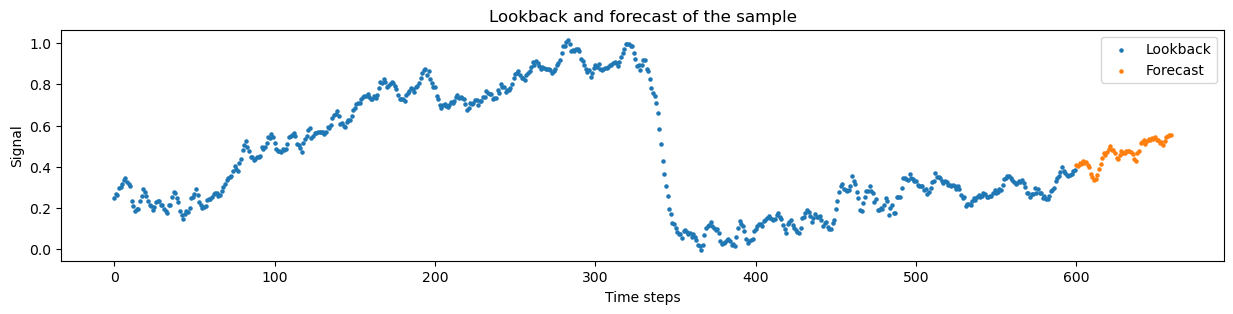

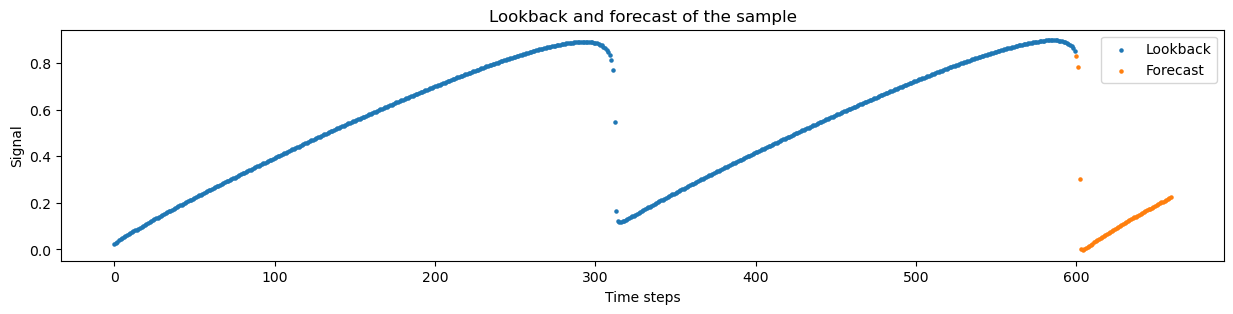

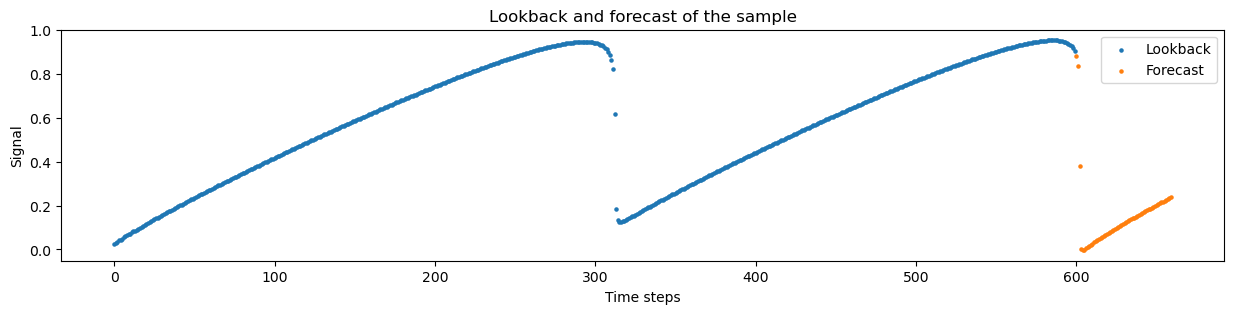

In [23]:
plot_example_sample(
    cascadia_data_dict["X_test_sc"],
    cascadia_data_dict["y_test_sc"],
    int(100 / efficiency_factor),
    LOOKBACK,
    FORECAST,
)
plot_example_sample(
    p4679_data_dict["X_test_sc"],
    p4679_data_dict["y_test_sc"],
    int(100 / efficiency_factor),
    LOOKBACK,
    FORECAST,
)
plot_example_sample(
    p4679_300s_data_dict["X_test_sc"],
    p4679_300s_data_dict["y_test_sc"],
    int(100 / efficiency_factor),
    LOOKBACK,
    FORECAST,
)

## Initialise and train models

In [24]:
# Model variables
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0
N_EPOCHS = 75
N_LAYERS = 1

# Plot variables
TITLE = "Original Time Series and Model Predictions"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 2600
ZOOM_MAX = 2800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

In [25]:
# Function to calculate the total size of tensors in a data dictionary


def calculate_total_size(data_dict):
    total_size_bytes = 0
    for key, tensor in data_dict.items():
        element_size = tensor.element_size()  # Size of each element in bytes
        num_elements = tensor.nelement()  # Number of elements in the tensor
        total_size_bytes += element_size * num_elements
    return total_size_bytes / 1e6  # Convert to megabytes


print(
    f"Cascadia data dictionary size: {calculate_total_size(cascadia_data_dict)} MB"
)
print(
    f"p4679 data dictionary size: {calculate_total_size(p4679_data_dict)} MB"
)
print(
    f"p4679_300s data dictionary size: {calculate_total_size(p4679_300s_data_dict)} MB"
)

Cascadia data dictionary size: 16.7904 MB
p4679 data dictionary size: 240.1344 MB
p4679_300s data dictionary size: 118.1664 MB


In [26]:
# Train Cascadia Model


model_cascadia = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)
# model_cascadia = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

cascadia_results_dict = train_model(
    model_cascadia, N_EPOCHS, cascadia_data_dict, cascadia_scaler_y, device
)

cascadia_results_dict = eval_model_on_test_set(
    model_cascadia,
    cascadia_results_dict,
    cascadia_data_dict,
    cascadia_scaler_y,
    device,
)

/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


Epoch [75/75], Train RMSE: 28371036.0000, Val RMSE: 59567288.0000: 100%|██████████| 75/75 [00:22<00:00,  3.37it/s]


In [27]:
# Train p4679 Model

model_p4679 = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)
# model_p4679 = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

p4679_results_dict = train_model(
    model_p4679, N_EPOCHS, p4679_data_dict, p4679_scaler_y, device
)

p4679_results_dict = eval_model_on_test_set(
    model_p4679, p4679_results_dict, p4679_data_dict, p4679_scaler_y, device
)

/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


Epoch [75/75], Train RMSE: 0.0265, Val RMSE: 0.0343: 100%|██████████| 75/75 [05:56<00:00,  4.75s/it]


In [28]:
# Train p4679_300s Model

model_p4679_300s = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)
# model_p4679_300s = lstm.MultiStepLSTMSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

p4679_300s_results_dict = train_model(
    model_p4679_300s,
    N_EPOCHS,
    p4679_300s_data_dict,
    p4679_300s_scaler_y,
    device,
)

p4679_300s_results_dict = eval_model_on_test_set(
    model_p4679_300s,
    p4679_300s_results_dict,
    p4679_300s_data_dict,
    p4679_300s_scaler_y,
    device,
)

/home/users/trr26/miniconda3/envs/gtc_env/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Training model on cuda


Epoch [75/75], Train RMSE: 0.0168, Val RMSE: 0.0288: 100%|██████████| 75/75 [03:21<00:00,  2.69s/it]


In [29]:
p4679_300s_model_eval_on_600s_test_results_dict = {}

p4679_results_dict = eval_model_on_test_set(
    model_p4679, p4679_results_dict, p4679_data_dict, p4679_scaler_y, device
)
p4679_300s_model_eval_on_600s_test_results_dict = eval_model_on_test_set(
    model_p4679_300s,
    p4679_300s_model_eval_on_600s_test_results_dict,
    p4679_data_dict,
    p4679_scaler_y,
    device,
)

print("p4679 model (600s) RMSE:", p4679_results_dict["test_rmse_list"])

print(
    "p4679 model (300s) evaluated on p4679 (600s) test set RMSE:",
    p4679_300s_model_eval_on_600s_test_results_dict["test_rmse_list"],
)

print("--------------------")

print("p4679 model (600s) R^2:", p4679_results_dict["test_r2_list"])

print(
    "p4679 model (300s) evaluated on p4679 (600s) test set R^2:",
    p4679_300s_model_eval_on_600s_test_results_dict["test_r2_list"],
)

p4679 model (600s) RMSE: 0.031067145988345146
p4679 model (300s) evaluated on p4679 (600s) test set RMSE: 0.03056292235851288
--------------------
p4679 model (600s) R^2: 0.8235599205147182
p4679 model (300s) evaluated on p4679 (600s) test set R^2: 0.8292413041927809


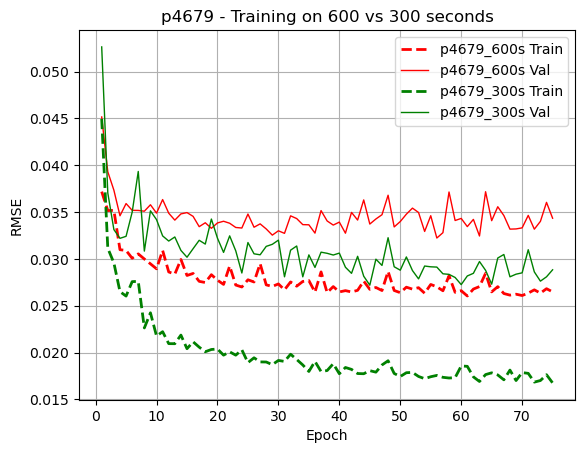

p4679 model (600s) Train RMSE: 0.0264755692332983
p4679 model (600s) Val RMSE: 0.034339867532253265
p4679 model (600s) Test RMSE: 0.031067145988345146
--------------------
p4679 model (300s) Train RMSE: 0.016754701733589172
p4679 model (300s) Val RMSE: 0.028832729905843735
p4679 model (300s) Test RMSE: 0.023652296513319016


In [30]:
# Plot p4679 train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_results_dict["train_rmse_list"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="p4679_600s Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_results_dict["val_rmse_list"],
    color="red",
    linestyle="-",
    linewidth=1,
    label="p4679_600s Val",
)

# Plot p4679_300s train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_300s_results_dict["train_rmse_list"],
    color="green",
    linestyle="--",
    linewidth=2,
    label="p4679_300s Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_300s_results_dict["val_rmse_list"],
    color="green",
    linestyle="-",
    linewidth=1,
    label="p4679_300s Val",
)

plt.title("p4679 - Training on 600 vs 300 seconds")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()

plt.yticks(
    np.arange(
        0.015,
        max(
            p4679_results_dict["train_rmse_list"]
            + p4679_results_dict["val_rmse_list"]
            + p4679_300s_results_dict["train_rmse_list"]
            + p4679_300s_results_dict["val_rmse_list"]
        ),
        0.005,
    )
)
plt.grid(True)
plt.show()

print(
    "p4679 model (600s) Train RMSE:", p4679_results_dict["train_rmse_list"][-1]
)
print("p4679 model (600s) Val RMSE:", p4679_results_dict["val_rmse_list"][-1])
print("p4679 model (600s) Test RMSE:", p4679_results_dict["test_rmse_list"])

print("--------------------")

print(
    "p4679 model (300s) Train RMSE:",
    p4679_300s_results_dict["train_rmse_list"][-1],
)
print(
    "p4679 model (300s) Val RMSE:",
    p4679_300s_results_dict["val_rmse_list"][-1],
)
print(
    "p4679 model (300s) Test RMSE:", p4679_300s_results_dict["test_rmse_list"]
)

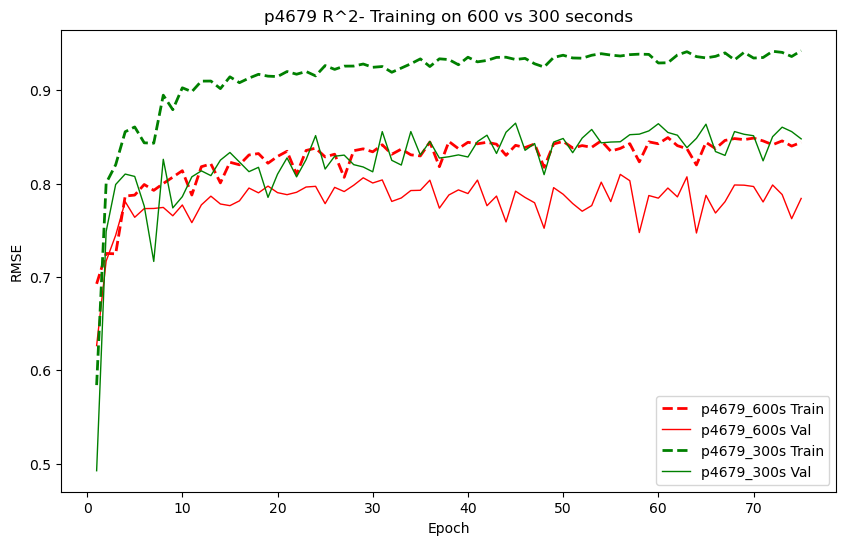

In [31]:
plt.figure(figsize=(10, 6))

# Plot p4679 train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_results_dict["train_r2_list"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="p4679_600s Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_results_dict["val_r2_list"],
    color="red",
    linestyle="-",
    linewidth=1,
    label="p4679_600s Val",
)

# Plot p4679_300s train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_300s_results_dict["train_r2_list"],
    color="green",
    linestyle="--",
    linewidth=2,
    label="p4679_300s Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    p4679_300s_results_dict["val_r2_list"],
    color="green",
    linestyle="-",
    linewidth=1,
    label="p4679_300s Val",
)

plt.title("p4679 R^2- Training on 600 vs 300 seconds")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

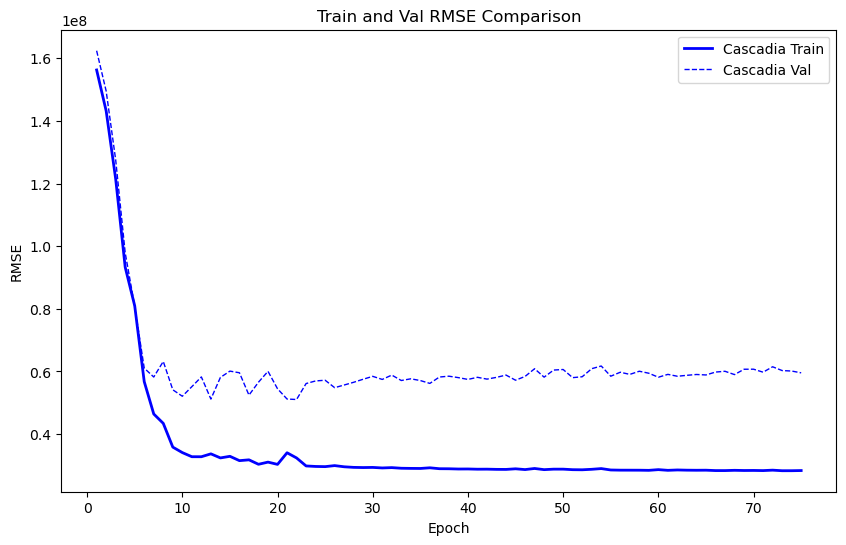

In [32]:
plt.figure(figsize=(10, 6))

# Plot Cascadia train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["train_rmse_list"],
    color="blue",
    linestyle="-",
    linewidth=2,
    label="Cascadia Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["val_rmse_list"],
    color="blue",
    linestyle="--",
    linewidth=1,
    label="Cascadia Val",
)


plt.title("Train and Val RMSE Comparison")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

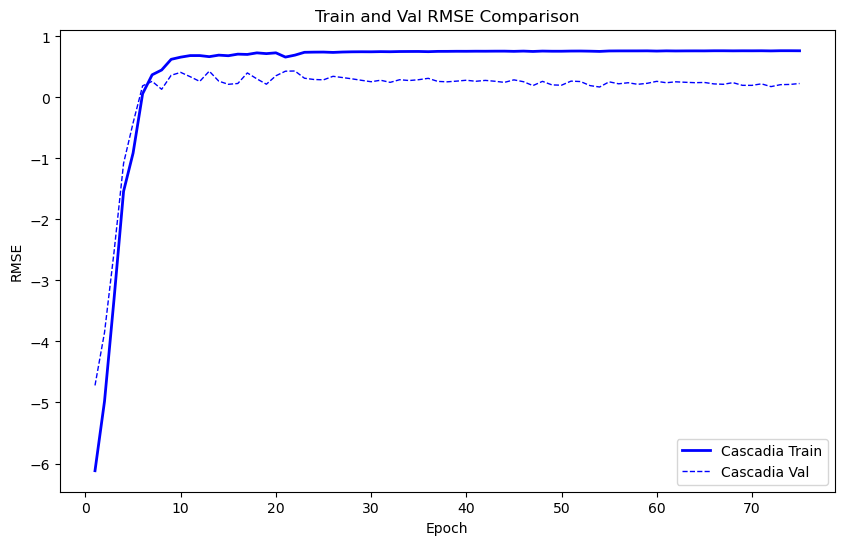

In [33]:
plt.figure(figsize=(10, 6))

# Plot Cascadia train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["train_r2_list"],
    color="blue",
    linestyle="-",
    linewidth=2,
    label="Cascadia Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["val_r2_list"],
    color="blue",
    linestyle="--",
    linewidth=1,
    label="Cascadia Val",
)


plt.title("Train and Val RMSE Comparison")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [34]:
cascadia_fine_tune_results_dict = train_model(
    model_p4679, N_EPOCHS, cascadia_data_dict, cascadia_scaler_y, device
)

cascadia_fine_tune_results_dict = eval_model_on_test_set(
    model_p4679,
    cascadia_fine_tune_results_dict,
    cascadia_data_dict,
    cascadia_scaler_y,
    device,
)

cascadia_results_dict = eval_model_on_test_set(
    model_cascadia,
    cascadia_results_dict,
    cascadia_data_dict,
    cascadia_scaler_y,
    device,
)

print("Cascadia model test MSE:", cascadia_results_dict["test_rmse_list"])
print(
    "Cascadia model pre-trained on p4679 (600s) test MSE:",
    cascadia_fine_tune_results_dict["test_rmse_list"],
)

print("--------------------")

print("Cascadia model test R^2:", cascadia_results_dict["test_r2_list"])
print(
    "Cascadia model pre-trained on p4679 (600s) test R^2:",
    cascadia_fine_tune_results_dict["test_r2_list"],
)

Training model on cuda


Epoch [75/75], Train RMSE: 17506868.0000, Val RMSE: 90399000.0000: 100%|██████████| 75/75 [00:22<00:00,  3.29it/s]


Cascadia model test MSE: 72354024.0
Cascadia model pre-trained on p4679 (600s) test MSE: 106653656.0
--------------------
Cascadia model test R^2: 0.0364260421409447
Cascadia model pre-trained on p4679 (600s) test R^2: -1.0869555889537899


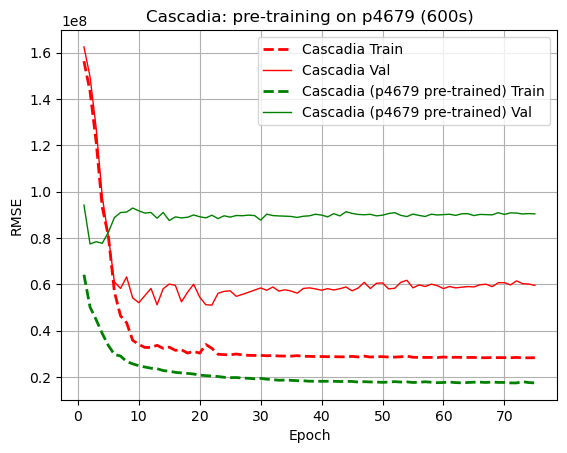

Cascadia Train RMSE: 28371036.0
Cascadia Val RMSE: 59567288.0
Cascadia Test RMSE: 72354024.0
--------------------
Cascadia (p4679 pre-trained) Train RMSE: 17506868.0
Cascadia (p4679 pre-trained) Val RMSE: 90399000.0
Cascadia (p4679 pre-trained) Test RMSE: 106653656.0


In [35]:
# Plot p4679 train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["train_rmse_list"],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Cascadia Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_results_dict["val_rmse_list"],
    color="red",
    linestyle="-",
    linewidth=1,
    label="Cascadia Val",
)

# Plot p4679_300s train and val RMSE
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_fine_tune_results_dict["train_rmse_list"],
    color="green",
    linestyle="--",
    linewidth=2,
    label="Cascadia (p4679 pre-trained) Train",
)
plt.plot(
    range(1, N_EPOCHS + 1),
    cascadia_fine_tune_results_dict["val_rmse_list"],
    color="green",
    linestyle="-",
    linewidth=1,
    label="Cascadia (p4679 pre-trained) Val",
)

plt.title("Cascadia: pre-training on p4679 (600s)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()

plt.grid(True)
plt.show()

print("Cascadia Train RMSE:", cascadia_results_dict["train_rmse_list"][-1])
print("Cascadia Val RMSE:", cascadia_results_dict["val_rmse_list"][-1])
print("Cascadia Test RMSE:", cascadia_results_dict["test_rmse_list"])

print("--------------------")

print(
    "Cascadia (p4679 pre-trained) Train RMSE:",
    cascadia_fine_tune_results_dict["train_rmse_list"][-1],
)
print(
    "Cascadia (p4679 pre-trained) Val RMSE:",
    cascadia_fine_tune_results_dict["val_rmse_list"][-1],
)
print(
    "Cascadia (p4679 pre-trained) Test RMSE:",
    cascadia_fine_tune_results_dict["test_rmse_list"],
)

In [38]:
torch.save(model_p4679.state_dict(), "Cascadia pre-trained.pt")
torch.save(model_cascadia.state_dict(), "Cascadia.pt")
torch.save(model_p4679_300s.state_dict(), "p4679.pt")

In [37]:
torch.cuda.empty_cache()